# Introdução ao Firedrake  

&nbsp;

## Parte 2: Elasticidade Linear

&nbsp;

Ministrante: **Diego Tavares Volpatto (LNCC/ESSS)**
&nbsp;

Encontro Acadêmico de Modelagem Computacional - XV EAMC (2022)

<tr>
<td> <img src="../img/logo_eamc.png" alt="Drawing" style="width: 200px;"/> </td>
<td> <img src="../img/banner.png" alt="Drawing" style="width: 550px;"/> </td>
</tr>

## Sumário

* Solucionar com FEM o problema da Elasticidade Linear para os deslocamentos (primal)
* Novas dicas e funcionalidades

# Elasticidade Linear

## Problema-modelo

A elasticidade linear é um modelo que descreve algumas situações de pequenas deformações. O objetivo aqui é demonstrar como solucionar um problema em que a incógnita é um vetor (e.g., campo de deslocamento).

### Forma forte

Vamos considerar o caso de pequenas deformações elásticas isotrópicas para fins didáticos. Dessa forma, a equação do momento linear de Cauchy se resume a:

\begin{equation}
\begin{aligned}
-\nabla \cdot \sigma &=f \text { em } \Omega \\[0.5em]
\sigma(u) &:=\lambda \operatorname{tr}(\varepsilon(u)) I+2 \mu \varepsilon(u) \\[0.5em]
\varepsilon(u) &:=\frac{1}{2}\left(\nabla u+(\nabla u)^{\top}\right)
\end{aligned}
\end{equation}

Note que a equação é também vetorial, $f: \Omega \to \mathbb{R}^n$.

### Forma fraca

Após algumas manipulações (em especial, o produto interno de um tensor simétrico com um antissimétrico é nulo), temos as formas:

\begin{equation}
\begin{aligned}
a(u, v) &:=\int_{\Omega} \sigma(u): \varepsilon(u) \mathrm{~d} x \\
L(v) &:=\int_{\Omega} f \cdot v \mathrm{~d} x+\int_{\Gamma_{T}} T \cdot v \mathrm{~d} s
\end{aligned}
\end{equation}

E o problema variacional é dado por:

\begin{equation}
a(u, v) = L(v)
\end{equation}

**Note** que $u$ e $v$ são campos vetoriais! Portanto e naturalmente, pertecem a espaços de funções vetoriais.

## Implementação

Temos agora todos os requisitos para a implementação. 

### Considerações do modelo

* Vamos considerar o domínio 2D alongado (barra): $\Omega = [0, L_x] \times [0, L_y]$, com $L_x = 1$ e $L_y = 0.1$ em metros.

* Condições de contorno: barra fixada nas duas extremidades. Portanto, $u_x = u_y = 0$ nas duas extremidades.

* Densidade do material $\rho = 0.01$ (kg / m$^3$) e gravidade $g = 9.8$ (m / s$^2$)

* Parâmetros do material: $\lambda = 0.4$ e $\mu = 1$.

### Importando o Firedrake

Como de costume:

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"  # necessário para o Firedrake

from firedrake import *
import matplotlib.pyplot as plt

### Definindo a malha

Parece esse problema, podemos usar uma função built-in do Firedrake.

In [2]:
Lx, Ly = 1.0, 0.1
num_elements_x, num_elements_y = 20, 20
mesh = RectangleMesh(num_elements_x, num_elements_y, Lx, Ly, quadrilateral=True)

### Funções e seu Espaço

Neste caso, o espaço de função é **vetorial**. Não há muitas diferenças, agora os graus de liberdade são para cada componente do vetor, e esses, por sua vez, pertecem ao espaço de função escalar relacionado.

In [3]:
degree = 1
family = "Lagrange"
V = VectorFunctionSpace(mesh, family, degree)

u = TrialFunction(V)
v = TestFunction(V)

### Parâmetros do material

Apenas atribuindo os valores que adotamos para esse problema:

In [4]:
rho = Constant(0.01)
g = Constant(9.8)
f = as_vector([0, -rho * g])  # poderia ser Constant([0, -rho * g])
mu = Constant(1)
lambda_ = Constant(0.4)

### Equações constitutivas

Vamos agora definir $\varepsilon(u)$ e $\sigma(u)$, de forma que não precisamos abrir suas contas na formulação variacional:

\begin{equation}
\begin{aligned}
\varepsilon(u) &:=\frac{1}{2}\left(\nabla u+(\nabla u)^{\top}\right) \\[0.5em]
\sigma(u) &:=\lambda \operatorname{tr}(\varepsilon(u)) I+2 \mu \varepsilon(u) 
\end{aligned}
\end{equation}

In [5]:
Id = Identity(mesh.geometric_dimension())  # tensor identidade


def epsilon(u):
    return (1. / 2.) * (grad(u) + grad(u).T)


def sigma(u):
    return lambda_ * div(u) * Id + 2 * mu * epsilon(u)

Note que poderíamos fazer:

In [6]:
def epsilon(u):
    return sym(grad(u))

### Formulação Variacional

Agora, podemos escrever a formulação variacional sem dificuldades:

\begin{equation}
\begin{aligned}
a(u, v) &:=\int_{\Omega} \sigma(u): \varepsilon(u) \mathrm{~d} x \\
L(v) &:=\int_{\Omega} f \cdot v \mathrm{~d} x+\int_{\Gamma_{T}} T \cdot v \mathrm{~d} s
\end{aligned}
\end{equation}

In [7]:
a = inner(sigma(u), epsilon(v)) * dx
L = dot(f, v) * dx  # note o produto interno

Por enquanto, vamos desconsiderar qualquer tração, temos apenas o efeito da força de corpo (gravidade).

### Condições de contorno

Temos a condição de contorno como barra fixa nas extremidades:

In [8]:
ux_bc, uy_bc = 0.0, 0.0
bcs = DirichletBC(V, as_vector([ux_bc, uy_bc]), [1, 2])

### Montando o Problema Variacional e seu solver

Sem grandes diferenças para outras casos, definimos o problema variacional:

In [9]:
u_h = Function(V)
# solve(a == L, u_h, bcs=bcs)  # não é boa prática, tem overhead
elasticity_problem = LinearVariationalProblem(a, L, u_h, bcs=bcs)

E seu solver associado (agora com exemplo usando o MUMPS ou GMRES):

In [10]:
solver_parameters = {
    "ksp_monitor": None,
    "ksp_converged_reason": None,
    "ksp_view": None,
    "mat_type": "aij",
    "ksp_type": "gmres",
    "pc_type": "ilu",
    'ksp_rtol': 1e-8,
    'ksp_max_it': 2000
}

In [11]:
solver_parameters = {
    "ksp_monitor": None,
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
}

In [12]:
elasticity_solver = LinearVariationalSolver(elasticity_problem, solver_parameters=solver_parameters)

### Solucionado

Executando o solver:

In [13]:
elasticity_solver.solve()

    Residual norms for firedrake_0_ solve.
    0 KSP Residual norm 4.715852255955e-04 
    1 KSP Residual norm 1.069118219739e-14 


### Visualizando alguns resultados

Primeiro de tudo, vamos verificar o campo de deslocamento e seus componentes:

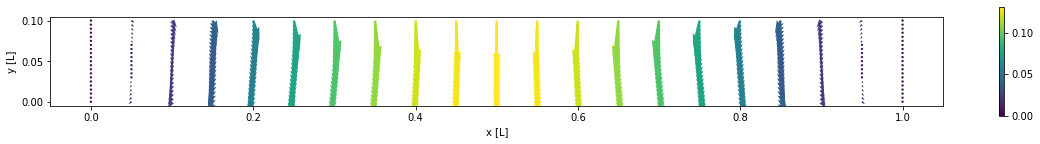

In [14]:
fig, axes = plt.subplots(figsize=(20, 2))

collection = quiver(u_h, axes=axes)
fig.colorbar(collection)
axes.set_aspect("equal")

plt.xlabel('x [L]')
plt.ylabel('y [L]')

plt.show()

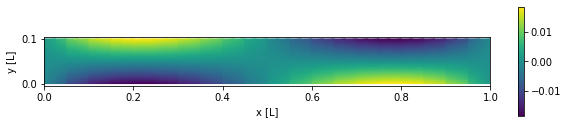

In [15]:
fig, axes = plt.subplots(figsize=(10, 2))

# Componente x
collection = tripcolor(u_h.sub(0), axes=axes)
fig.colorbar(collection)
axes.set_aspect("equal")

plt.xlabel('x [L]')
plt.ylabel('y [L]')

axes.set_xlim([0, 1])

plt.show()

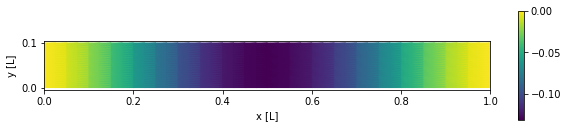

In [16]:
fig, axes = plt.subplots(figsize=(10, 2))

# Componente y
collection = tripcolor(u_h.sub(1), axes=axes)
fig.colorbar(collection)
axes.set_aspect("equal")

plt.xlabel('x [L]')
plt.ylabel('y [L]')

axes.set_xlim([0, 1])

plt.show()

Agora podemos ver a deformação na barra vendo a malha antes e depois.

Vamos deslocar a malha com o campo de deslocamento obtido:

In [17]:
original_mesh = interpolate(SpatialCoordinate(mesh), V)
displaced_coordinates = interpolate(original_mesh + u_h, V)
displaced_mesh = Mesh(displaced_coordinates)

Antes:

Depois:

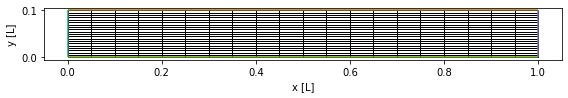

In [18]:
fig, axes = plt.subplots(figsize=(8, 6))

triplot(mesh, axes=axes)
axes.set_aspect("equal")

# Setting the xy-labels
plt.xlabel('x [L]')
plt.ylabel('y [L]')

# Displaying in the screen
plt.tight_layout()
plt.show()

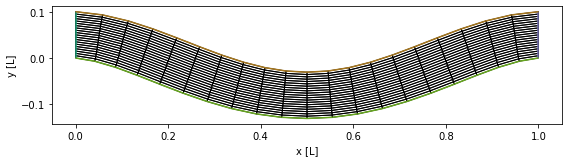

In [19]:
fig, axes = plt.subplots(figsize=(8, 6))

triplot(displaced_mesh, axes=axes)
axes.set_aspect("equal")

# Setting the xy-labels
plt.xlabel('x [L]')
plt.ylabel('y [L]')

# Displaying in the screen
plt.tight_layout()
plt.show()